# Home Work 6. Градиентный бустинг (AdaBoost)

Для выполнения домашнего задания будем использовать файл Lesson_6_extended.ipynb (из материалов к уроку):

### Задача 1.  
**Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

%matplotlib inline

In [2]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
       
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [4]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [6]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

**Зависимость ошибки от количества деревьев в ансамбле**  

Зададим начальные коэффициенты $\gamma = 1$, максимальная глубина деревьев 3, шаг градиентного бустинга $\eta = 0.1$. Будем менять число деревьев в ансамбле от 1 до 40.

In [8]:
max_depth = 3
eta = 0.1
n_trees_max = 40
n_trees_arr = [i+1 for i in range(n_trees_max)]

trees, train_errors, test_errors = gb_fit(n_trees_max, max_depth, X_train, X_test, y_train, y_test, eta)

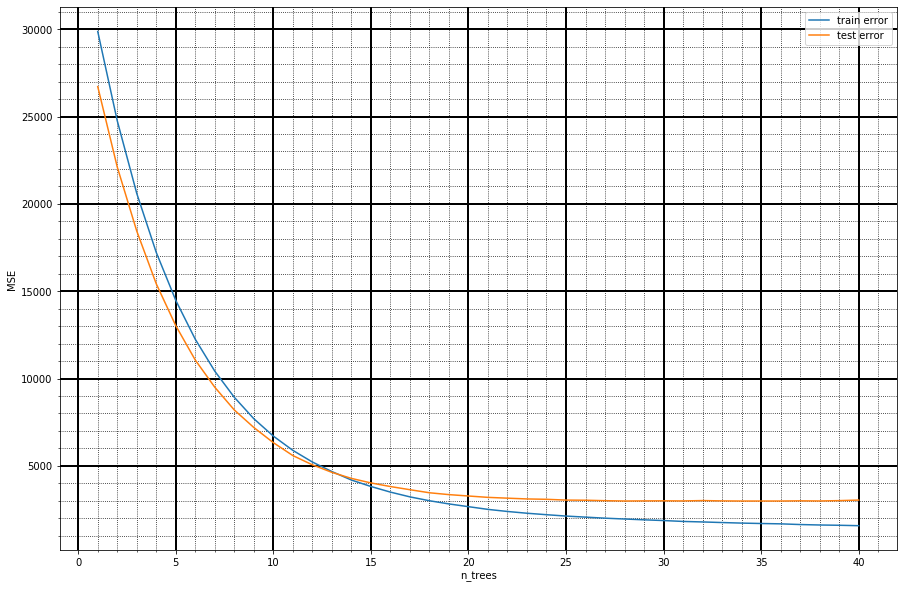

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(n_trees_arr, train_errors, label='train error')
plt.plot(n_trees_arr, test_errors, label='test error')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.minorticks_on()
plt.grid(which='major',
        color = 'k', 
        linewidth = 2)
plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
plt.legend()
plt.show()

**Вывод**  
При увеличении количества деревьев в ансамбле точность модели увеличивается.  
Графики изменения MSE модели обучающей и тестовой выборок пересекаются на графике в районе числа деревьев равном 13.  
Далее сохраняется увеличение точности на тренировочной выборке.  
На тестовой выборке точность модели растёт до количества деревьев равном примерно 27, далее увеличение точности останавливается. Соответственно дальнейшее увеличение деревьев не имеет смысла.

**Зависимость ошибки от максимальной глубины деревьев.**

Зададим число деревьев равное 20. Будем менять глубину деревьев от 1 до 20.

In [10]:
n_trees = 20
eta = 0.1
max_depth_arr = np.arange(1, 21, 1)

train_errors_list = []
test_errors_list = []
for max_depth in max_depth_arr:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    train_errors_list.append(train_errors[-1])
    test_errors_list.append(test_errors[-1])

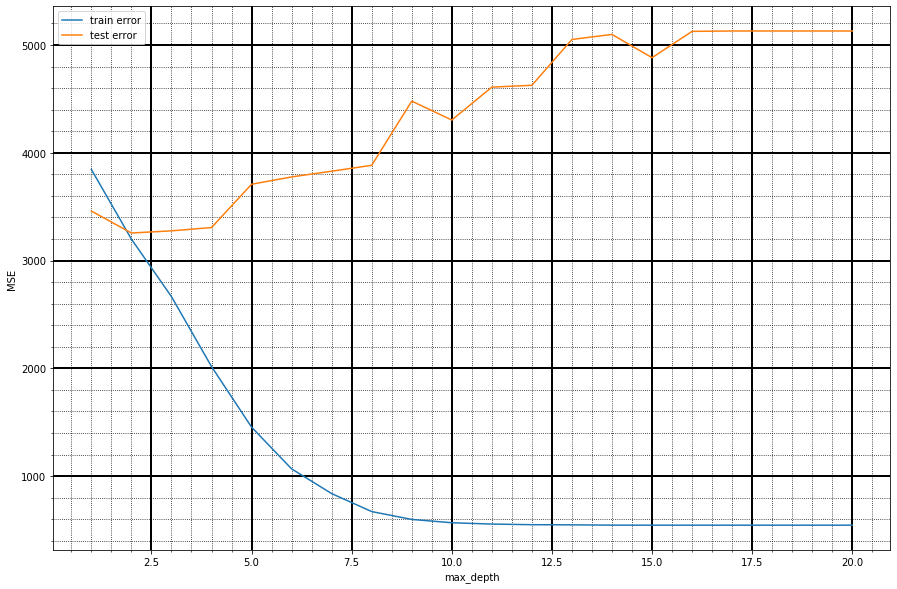

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(max_depth_arr, train_errors_list, label='train error')
plt.plot(max_depth_arr, test_errors_list, label='test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.minorticks_on()
plt.grid(which='major',
        color = 'k', 
        linewidth = 2)
plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
plt.legend()
plt.show()

**Вывод**  
Оптимальная глубина деревьев, исходя из графика, лежит в районе значения 2. 
Далее ошибка по тестовой выборке начинает расти, что говорит о переобучении нашей модели.

### Задача*.  
**Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [12]:
# Получение бутстрап-выбороки

def get_bootstrap(data, labels, alpha):
    n_samples = int(alpha * X.shape[0])
    sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
    
    return data[sample_indexes], labels[sample_indexes]

In [13]:
# Обучение модели со стохастическим градиентным бустингом
def gb_fit_bootstarap(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []    

    for i in range(n_trees):
        X_bootstrap, y_bootstrap = get_bootstrap(X_train, y_train, 0.5)
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        if len(trees) == 0:
            tree.fit(X_bootstrap, y_bootstrap)            
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_bootstrap, trees, eta)
        
            # алгоритмы начиная со второго обучаем на сдвиг

            tree.fit(X_bootstrap, residual(y_bootstrap, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [14]:
max_depth = 3
eta = 0.1
n_trees_max = 10
n_trees_arr = [i+1 for i in range(n_trees_max)]

In [15]:
%%time
trees, train_errors, test_errors = gb_fit(n_trees_max, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.82 s


In [16]:
%%time
trees_b, train_errors_b, test_errors_b = gb_fit_bootstarap(n_trees_max, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.63 s


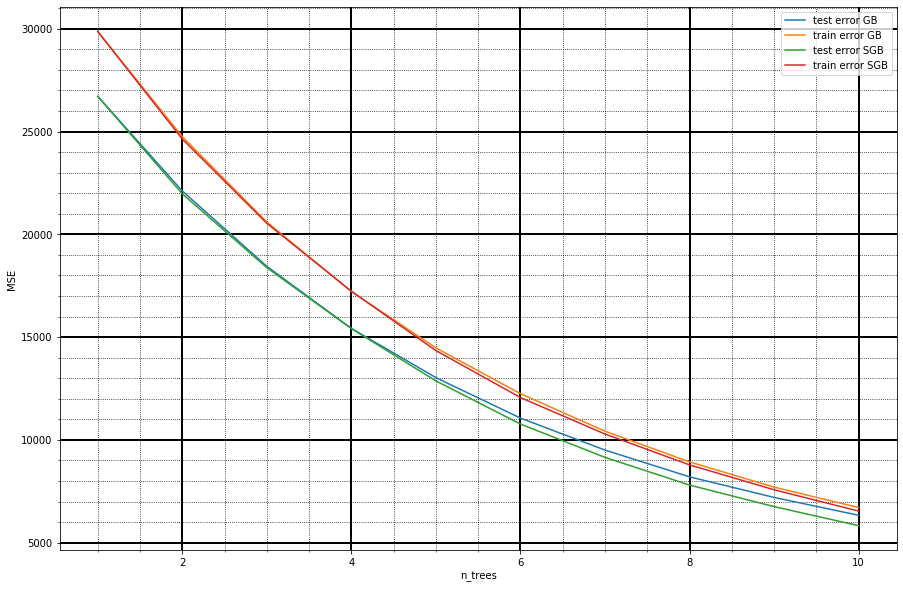

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(n_trees_arr, test_errors, label='test error GB')
plt.plot(n_trees_arr, train_errors, label='train error GB')
plt.plot(n_trees_arr, test_errors_b, label='test error SGB')
plt.plot(n_trees_arr, train_errors_b, label='train error SGB')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.minorticks_on()
plt.grid(which='major',
        color = 'k', 
        linewidth = 2)
plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
plt.legend()
plt.show()

**Вывод**  
Результат примерно одинаковый. При большем количестве шагов результат у модели стохастического градиентного бустинга чуть лучше.